# Clasificador para estimar el espaciamiento espectral

- [x] Evolucionar la red neuronal a un clasificador basado en los mejores parámetros y probar con diferente número de clases (de 2 a 5 clases, como Alejandro).
- [ ] Añadir el caso sin tomar la OSNR como característica en clasificación.
- [x] Cambiar marcadores para que sean distinguibles FCM vs. GKM (Ser consistente para train y test).
- [ ] Graficar matrices de confusión.
- [ ] Añadir el caso sin tomar la OSNR como característica en regresión.
- [ ] Demodular usando redes neuronales (empezar con pocas neuronas y una sola capa oculta).

In [1]:
# Imports
import sofa
import polars as pl
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import tensorflow.keras as ker

from sklearn.metrics import (accuracy_score, f1_score, multilabel_confusion_matrix,
                             ConfusionMatrixDisplay)
from sklearn.model_selection import cross_validate, KFold, train_test_split
from sklearn.preprocessing import StandardScaler

from tensorflow.keras import models, regularizers, Sequential, utils
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from time import time

2023-06-01 23:38:21.903170: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-01 23:38:21.979065: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-01 23:38:22.104284: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-01 23:38:22.105293: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-01 23:38:23.193194: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

## Funciones globales

In [2]:
def calc_once(varname, fn, args):
    """ Calculate a variable only once. """
    if varname not in globals():
        return fn(**args)
    return eval(varname)

In [3]:
def plot_loss(score, end=500):
    """ Plot loss evolution for each k-fold. """
    for k, loss in enumerate(score["loss"]):
        loss_length = len(loss.history["loss"])
        loss_values = loss.history["loss"][:end if loss_length > end else loss_length]
        epoch_values = range(end if loss_length > end else loss_length)
        plt.plot(epoch_values, loss_values, label=f"k = {k+1}")

def plot_losses(scores, scenario, cmp_fn, cmp_values=[], end=500, based_on_index=False):
    """ Plot loss graphics for each scenario. """
    # Handle default cmp_values
    if len(cmp_values) == 0:
        cmp_values = np.zeros(len(scores))
        
    fig_loss = plt.figure(figsize=(16, 3*len(scores)), layout="constrained")
    fig_loss.suptitle(f"{scenario} loss history", size="x-large")
    
    for index, (score, cmps) in enumerate(zip(scores, cmp_values)):
        plt.subplot(len(scores)//2, 2, index + 1)
        plot_loss(score, end=end)
        
        plt.title(cmp_fn(cmps) if not based_on_index else cmp_fn(index))
        
        plt.xlabel("Iteration")
        plt.ylabel("Loss")
        
        # Transparent white box black edge legend
        legend = plt.legend(loc="upper right", edgecolor="black")
        legend.get_frame().set_alpha(None)
        legend.get_frame().set_facecolor((1, 1, 1, 0.01))
        
        plt.grid(True)

def plot_scores(scores, x_values, scenario, score_names, data_type,
                label, xlabel, markers=[], colors=[], based_on_index=False,
                log=False, multiple_points=False, plot_train=True):
    fig_scores = plt.figure(figsize=(16, 6), layout="constrained")
    fig_scores.suptitle(f"{scenario} scores")
    i = 0
    for sn in score_names:
        ax = plt.subplot(1, len(score_names), i+1)
        for dt in data_type:
            if not plot_train and dt == "train":
                continue
            points = [np.average(score[sn][dt]) for score in scores]
            if not multiple_points:
                label_value = ""
                plt.scatter(x_values, points, marker=markers[0 if dt == "train" else 1],
                            label=f"{dt.title()} {label(i)}", s=100)
            else:
                label_value = ""
                points1 = points[::2]
                points2 = points[1::2]
                plt.scatter(x_values, points1, marker=markers[0 if dt == "train" else 1],
                            color=colors[0 if dt == "train" else 1],
                            label=f"{dt.title()} {label(0)}", s=100)
                plt.scatter(x_values, points2, marker=markers[2 if dt == "train" else 3],
                            color=colors[2 if dt == "train" else 3],
                            label=f"{dt.title()} {label(1)}", s=100)
            title = ""
            if sn == "r2":
                title = "R²"
            elif sn == "acc":
                title = "Accuracy"
            else:
                title = sn.upper()
            plt.title(title)
                
        plt.xlabel(xlabel)
        # Adjust logarithmic scale if requested
        if log:
            plt.xscale("log", base=2)
            
        # Make integer xticks if matches}
        if type(x_values[0]) == np.int64:
            ax.set_xticks(x_values)
            
        if type(x_values[0]) == str:
            ax.set_xticks(range(len(x_values)), x_values)
            
        # Shrink current axis by 20%
        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

        # Transparent white box black edge legend
        legend = plt.legend(loc="center left", bbox_to_anchor=(1, 0.5),
                            edgecolor="black")
        legend.get_frame().set_alpha(None)
        legend.get_frame().set_facecolor((1, 1, 1, 0.01))

        plt.grid(True)
        i += 1
    plt.show()

### Clasificación

In [4]:
def classificator(df, interval_lst, column_name):
    """Transforms a dataframe's column into classes"""
    array = df[column_name].to_numpy()
    indexes_lst = []
    for i, interval in enumerate(interval_lst):
        lower_limit, upper_limit = interval
        indexes_lst.append(np.intersect1d(np.where(lower_limit < array), np.where(array <= upper_limit)))
    
    classfull = df[column_name]
    for index, indexes in enumerate(indexes_lst):
        classfull[indexes] = index

    df_classfull = df.clone()
    df_classfull.replace(column_name, classfull)
    
    return df_classfull


def classifier_model(input_dim, layers_props_lst, classes_n, loss_fn):
    """ Compile a sequential model for classification purposes. """
    model = ker.Sequential()
    # Hidden layers
    for i, layer_props in enumerate(layers_props_lst):
        if i == 0:
            model.add(ker.layers.Dense(**layer_props, input_dim=input_dim))
        else:
            model.add(ker.layers.Dense(**layer_props))
    # Classifier
    model.add(ker.layers.Dense(units=classes_n, activation="softmax"))

    model.compile(loss=loss_fn, optimizer="adam")
    return model    


def classification_crossvalidation(X, y, n_splits, layer_props, classes_n, loss_fn, callbacks):
    """ Crossvalidation of a classification network. """
    # Store initial time
    t0 = time()

    # Scores dict
    scores = {}
    scores["loss"] = []
    scores["acc"] = {"train": [], "test": []}
    scores["f1"] = {"train": [], "test": []}
    scores["cm"] = {"train": [], "test": []}
    
    # K-fold crossvalidation
    kf = KFold(n_splits=n_splits, shuffle=True)

    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Input variables standarizer
        sc = StandardScaler()
        X_train = sc.fit_transform(X_train)
        X_test_kf = sc.transform(X_test)
        
        model = classifier_model(X_train.shape[1], layer_props, classes_n, loss_fn)
        
        # Save test scalar loss
        if callbacks:
            loss = model.fit(
                X_train, y_train, epochs=5000, batch_size=64, verbose=0, callbacks=callbacks
            )
        else:
            loss = model.fit(X_train, y_train, epochs=5000, batch_size=64, verbose=0)
        print(f"Needed iterations: {len(loss.history['loss'])}")
        
        # Predict using train values
        fuzzy_predictions_train = model.predict(X_train)
        # Predict using test values
        fuzzy_predictions_test = model.predict(X_test_kf)
        
        # Assign class based on higher probability in membership vector
        predictions_train = np.array([np.argmax(fuzzy_prediction) for fuzzy_prediction in fuzzy_predictions_train])
        predictions_test = np.array([np.argmax(fuzzy_prediction) for fuzzy_prediction in fuzzy_predictions_test])

        # Dataframe for better visualization
        train_data_train = pl.DataFrame(
            {"ICI": [y_train], "Predicted ICI": [predictions_train]}
        )
        train_data_test = pl.DataFrame(
            {"ICI": [y_test], "Predicted ICI": [predictions_test]}
        )

        # Accuracy
        acc_score_train = accuracy_score(
            *train_data_train["ICI"], *train_data_train["Predicted ICI"]
        )
        acc_score_test = accuracy_score(
            *train_data_test["ICI"], *train_data_test["Predicted ICI"]
        )

        # F1
        f1_score_train = f1_score(
            *train_data_train["ICI"], *train_data_train["Predicted ICI"],
            average="micro"
        )
        f1_score_test = f1_score(
            *train_data_test["ICI"], *train_data_test["Predicted ICI"],
            average="micro"
        )
         
        # Confusion Matrix
        cm_score_train = multilabel_confusion_matrix(
            *train_data_train["ICI"], *train_data_train["Predicted ICI"]
        )
        cm_score_test = multilabel_confusion_matrix(
            *train_data_test["ICI"], *train_data_test["Predicted ICI"]
        )

        # Append to lists
        scores["loss"].append(loss)
        scores["acc"]["train"].append(acc_score_train)
        scores["acc"]["test"].append(acc_score_test)
        scores["f1"]["train"].append(f1_score_train)
        scores["f1"]["test"].append(f1_score_test)
        scores["cm"]["train"].append(cm_score_train)
        scores["cm"]["test"].append(cm_score_test)
        
    print(f"Time elapsed: {(time() - t0)/60:.2f} minutes")

    return scores


def test_classification_model(data, n_splits, max_neurons, activations, classes_n,
                               use_osnr=True, loss_fn="sparse_categorical_crossentropy"):
    """ Test a spectral overlapping classification model with given parameters. """
    # Set variable number
    var_n = 17 if use_osnr else 16
    
    # Split variables
    # Variables
    X = np.array(data[:, 0:var_n]).T
    # Tags
    y = np.array(data[:, 19:20]).T
    
    # Layer properties
    layer_props = [
        {"units": max_neurons // (2**i), "activation": activation}
        for i, activation in enumerate(activations)
    ]
    print(layer_props)
    callbacks = [
        EarlyStopping(monitor="loss", patience=30, mode="min", restore_best_weights=True)
    ]
    
    return classification_crossvalidation(X, y, n_splits, layer_props, classes_n, loss_fn, callbacks)

def plot_classes_scores(scores, scenario):
    score_names = ["acc"]
    data_type = ["train", "test"]
    markers = ["o", "D", "o", "D"]
    colors = ["dodgerblue", "dodgerblue", "red", "red"]
    
    # Plot loss
    plot_losses(scores, scenario, 
                lambda index: f"{'FCM' if index%2==0 else 'GKM'} {'B2B' if index<2 else 'optical fiber at ' + ('0' if index<4 else '9') + ' dBm'}",
                based_on_index=True)
    
    # Plot scores
    plot_scores(scores, ["B2B", "0 dBm", "9 dBm"], scenario, score_names,
                data_type, label=lambda index: f"{'FCM' if index%2==0 else 'GKM'}",
                xlabel="Scenario", markers=markers, colors=colors, multiple_points=True,
                based_on_index=True)
    plt.show()

## Restaurar variables

### Clasificación con 2 clases

In [5]:
%store -r scores_2classes_FCM_B2B
%store -r scores_2classes_GKM_B2B

%store -r scores_2classes_FCM_fiber0
%store -r scores_2classes_GKM_fiber0

%store -r scores_2classes_FCM_fiber9
%store -r scores_2classes_GKM_fiber9

%store -r scores_2classes_woOSNR_FCM_B2B
%store -r scores_2classes_woOSNR_GKM_B2B

%store -r scores_2classes_woOSNR_FCM_fiber0
%store -r scores_2classes_woOSNR_GKM_fiber0

%store -r scores_2classes_woOSNR_FCM_fiber9
%store -r scores_2classes_woOSNR_GKM_fiber9

### Clasificación con 3 clases

In [6]:
%store -r scores_3classes_FCM_B2B
%store -r scores_3classes_GKM_B2B

%store -r scores_3classes_FCM_fiber0
%store -r scores_3classes_GKM_fiber0

%store -r scores_3classes_FCM_fiber9
%store -r scores_3classes_GKM_fiber9

%store -r scores_3classes_woOSNR_FCM_B2B
%store -r scores_3classes_woOSNR_GKM_B2B

%store -r scores_3classes_woOSNR_FCM_fiber0
%store -r scores_3classes_woOSNR_GKM_fiber0

%store -r scores_3classes_woOSNR_FCM_fiber9
%store -r scores_3classes_woOSNR_GKM_fiber9

### Clasificación con 4 clases

In [7]:
%store -r scores_4classes_FCM_B2B
%store -r scores_4classes_GKM_B2B

%store -r scores_4classes_FCM_fiber0
%store -r scores_4classes_GKM_fiber0

%store -r scores_4classes_FCM_fiber9
%store -r scores_4classes_GKM_fiber9

%store -r scores_4classes_woOSNR_FCM_B2B
%store -r scores_4classes_woOSNR_GKM_B2B

%store -r scores_4classes_woOSNR_FCM_fiber0
%store -r scores_4classes_woOSNR_GKM_fiber0

%store -r scores_4classes_woOSNR_FCM_fiber9
%store -r scores_4classes_woOSNR_GKM_fiber9

### Clasificación con 5 clases

In [8]:
%store -r scores_5classes_FCM_B2B
%store -r scores_5classes_GKM_B2B

%store -r scores_5classes_FCM_fiber0
%store -r scores_5classes_GKM_fiber0

%store -r scores_5classes_FCM_fiber9
%store -r scores_5classes_GKM_fiber9

%store -r scores_5classes_woOSNR_FCM_B2B
%store -r scores_5classes_woOSNR_GKM_B2B

%store -r scores_5classes_woOSNR_FCM_fiber0
%store -r scores_5classes_woOSNR_GKM_fiber0

%store -r scores_5classes_woOSNR_FCM_fiber9
%store -r scores_5classes_woOSNR_GKM_fiber9

## Cargar los datos

### FCM

In [9]:
data_file_FCM = "../Databases/CaractFCM.csv"
df_FCM = pl.read_csv(data_file_FCM, dtypes=[pl.Float64], has_header=False)

### GKM

In [10]:
data_file_GKM = "../Databases/CaractGKM.csv"
df_GKM = pl.read_csv(data_file_GKM, dtypes=[pl.Float64], infer_schema_length = 10000, has_header=False)

# Clasificador

## 2 clases

### FCM

In [ ]:
interval_lst = [(0, 35), (35, 50)]
df_2classes_FCM = classificator(df_FCM, interval_lst, "column_20")

# Scenarios split
# Back-to-back (B2B)
df_2classes_FCM_B2B = df_2classes_FCM[0:987, :]
# 0dBm optical fiber
df_2classes_FCM_fiber0 = df_2classes_FCM[988:1520, :]
# 9dBm optical fiber
df_2classes_FCM_fiber9 = df_2classes_FCM[1521:, :]

#### B2B

In [ ]:
args = {"data": df_2classes_FCM_B2B, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy"}
scores_2classes_FCM_B2B = calc_once("scores_2classes_FCM_B2B", test_classification_model, args)

In [ ]:
args = {"data": df_2classes_FCM_B2B, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy", "use_osnr": False}
scores_2classes_woOSNR_FCM_B2B = calc_once("scores_2classes_woOSNR_FCM_B2B", test_classification_model, args)

#### Fibra óptica a 0dBm

In [ ]:
args = {"data": df_2classes_FCM_fiber0, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy"}
scores_2classes_FCM_fiber0 = calc_once("scores_2classes_FCM_fiber0", test_classification_model, args)

In [ ]:
args = {"data": df_2classes_FCM_fiber0, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy", "use_osnr": False}
scores_2classes_woOSNR_FCM_fiber0 = calc_once("scores_2classes_woOSNR_FCM_fiber0", test_classification_model, args)

#### Fibra óptica a 9dBm

In [ ]:
args = {"data": df_2classes_FCM_fiber9, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy"}
scores_2classes_FCM_fiber9 = calc_once("scores_2classes_FCM_fiber9", test_classification_model, args)

In [ ]:
args = {"data": df_2classes_FCM_fiber9, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy", "use_osnr": False}
scores_2classes_woOSNR_FCM_fiber9 = calc_once("scores_2classes_woOSNR_FCM_fiber9", test_classification_model, args)

### GKM

In [ ]:
interval_lst = [(0, 35), (35, 50)]
df_2classes_GKM = classificator(df_GKM, interval_lst, "column_20")

# Scenarios split
# Back-to-back (B2B)
df_2classes_GKM_B2B = df_2classes_GKM[0:987, :]
# 0dBm optical fiber
df_2classes_GKM_fiber0 = df_2classes_GKM[988:1520, :]
# 9dBm optical fiber
df_2classes_GKM_fiber9 = df_2classes_GKM[1521:, :]

#### B2B

In [ ]:
args = {"data": df_2classes_GKM_B2B, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy"}
scores_2classes_GKM_B2B = calc_once("scores_2classes_GKM_B2B", test_classification_model, args)

In [ ]:
args = {"data": df_2classes_GKM_B2B, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy", "use_osnr": False}
scores_2classes_woOSNR_GKM_B2B = calc_once("scores_2classes_woOSNR_GKM_B2B", test_classification_model, args)

#### Fibra óptica a 0dBm

In [ ]:
args = {"data": df_2classes_GKM_fiber0, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy"}
scores_2classes_GKM_fiber0 = calc_once("scores_2classes_GKM_fiber0", test_classification_model, args)

In [ ]:
args = {"data": df_2classes_GKM_fiber0, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy", "use_osnr": False}
scores_2classes_woOSNR_GKM_fiber0 = calc_once("scores_2classes_woOSNR_GKM_fiber0", test_classification_model, args)

#### Fibra óptica a 9dBm

In [ ]:
args = {"data": df_2classes_GKM_fiber9, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy"}
scores_2classes_GKM_fiber9 = calc_once("scores_2classes_GKM_fiber9", test_classification_model, args)

In [ ]:
args = {"data": df_2classes_GKM_fiber9, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy", "use_osnr": False}
scores_2classes_woOSNR_GKM_fiber9 = calc_once("scores_2classes_woOSNR_GKM_fiber9", test_classification_model, args)

In [ ]:
%store scores_2classes_FCM_B2B
%store scores_2classes_GKM_B2B
%store scores_2classes_FCM_fiber0
%store scores_2classes_GKM_fiber0
%store scores_2classes_FCM_fiber9
%store scores_2classes_GKM_fiber9

%store scores_2classes_woOSNR_FCM_B2B
%store scores_2classes_woOSNR_GKM_B2B
%store scores_2classes_woOSNR_FCM_fiber0
%store scores_2classes_woOSNR_GKM_fiber0
%store scores_2classes_woOSNR_FCM_fiber9
%store scores_2classes_woOSNR_GKM_fiber9

### Gráficas

In [ ]:
scores = [scores_2classes_FCM_B2B, scores_2classes_GKM_B2B, scores_2classes_FCM_fiber0, scores_2classes_GKM_fiber0, scores_2classes_FCM_fiber9, scores_2classes_GKM_fiber0]
plot_classes_scores(scores, "2 classes evaluation")

## 3 clases

### FCM

In [ ]:
interval_lst = [(0, 32), (32, 35), (35, 50)]
df_3classes_FCM = classificator(df_FCM, interval_lst, "column_20")

# Scenarios split
# Back-to-back (B2B)
df_3classes_FCM_B2B = df_3classes_FCM[0:987, :]
# 0dBm optical fiber
df_3classes_FCM_fiber0 = df_3classes_FCM[988:1520, :]
# 9dBm optical fiber
df_3classes_FCM_fiber9 = df_3classes_FCM[1521:, :]

#### B2B

In [ ]:
args = {"data": df_3classes_FCM_B2B, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy"}
scores_3classes_FCM_B2B = calc_once("scores_3classes_FCM_B2B", test_classification_model, args)

In [ ]:
args = {"data": df_3classes_FCM_B2B, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy", "use_osnr": False}
scores_3classes_woOSNR_FCM_B2B = calc_once("scores_3classes_woOSNR_FCM_B2B", test_classification_model, args)

#### Fibra óptica a 0dBm

In [ ]:
args = {"data": df_3classes_FCM_fiber0, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy"}
scores_3classes_FCM_fiber0 = calc_once("scores_3classes_FCM_fiber0", test_classification_model, args)

In [ ]:
args = {"data": df_3classes_FCM_fiber0, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy", "use_osnr": False}
scores_3classes_woOSNR_FCM_fiber0 = calc_once("scores_3classes_woOSNR_FCM_fiber0", test_classification_model, args)

#### Fibra óptica a 9dBm

In [ ]:
args = {"data": df_3classes_FCM_fiber9, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy"}
scores_3classes_FCM_fiber9 = calc_once("scores_3classes_FCM_fiber9", test_classification_model, args)

In [88]:
args = {"data": df_3classes_FCM_fiber9, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy", "use_osnr": False}
scores_3classes_woOSNR_FCM_fiber9 = calc_once("scores_3classes_woOSNR_FCM_fiber9", test_classification_model, args)

Needed iterations: 124
6/6 [==============================] - 0s 920us/step
Needed iterations: 225
6/6 [==============================] - 0s 815us/step
Needed iterations: 212
6/6 [==============================] - 0s 1ms/step
Time elapsed: 0.30 minutes


### GKM

In [89]:
interval_lst = [(0, 32), (32, 35), (35, 50)]
df_3classes_GKM = classificator(df_GKM, interval_lst, "column_20")

# Scenarios split
# Back-to-back (B2B)
df_3classes_GKM_B2B = df_3classes_GKM[0:987, :]
# 0dBm optical fiber
df_3classes_GKM_fiber0 = df_3classes_GKM[988:1520, :]
# 9dBm optical fiber
df_3classes_GKM_fiber9 = df_3classes_GKM[1521:, :]

#### B2B

In [90]:
args = {"data": df_3classes_GKM_B2B, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy"}
scores_3classes_GKM_B2B = calc_once("scores_3classes_GKM_B2B", test_classification_model, args)

In [91]:
args = {"data": df_3classes_GKM_B2B, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy", "use_osnr": False}
scores_3classes_woOSNR_GKM_B2B = calc_once("scores_3classes_woOSNR_GKM_B2B", test_classification_model, args)

[{'units': 256, 'activation': 'relu'}, {'units': 128, 'activation': 'tanh'}, {'units': 64, 'activation': 'sigmoid'}]
Needed iterations: 277
7/7 [==============================] - 0s 837us/step
Needed iterations: 296
7/7 [==============================] - 0s 1ms/step
Needed iterations: 279
7/7 [==============================] - 0s 905us/step
Needed iterations: 239
7/7 [==============================] - 0s 753us/step
Needed iterations: 346
7/7 [==============================] - 0s 1ms/step
Time elapsed: 0.38 minutes


#### Fibra óptica a 0dBm

In [92]:
args = {"data": df_3classes_GKM_fiber0, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy"}
scores_3classes_GKM_fiber0 = calc_once("scores_3classes_GKM_fiber0", test_classification_model, args)

In [93]:
args = {"data": df_3classes_GKM_fiber0, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy", "use_osnr": False}
scores_3classes_woOSNR_GKM_fiber0 = calc_once("scores_3classes_woOSNR_GKM_fiber0", test_classification_model, args)

[{'units': 256, 'activation': 'relu'}, {'units': 128, 'activation': 'tanh'}, {'units': 64, 'activation': 'sigmoid'}]
Needed iterations: 342
4/4 [==============================] - 0s 1ms/step
Needed iterations: 355
4/4 [==============================] - 0s 1ms/step
Needed iterations: 373
4/4 [==============================] - 0s 917us/step
Needed iterations: 178
4/4 [==============================] - 0s 1ms/step
Needed iterations: 223
4/4 [==============================] - 0s 1ms/step
Time elapsed: 0.26 minutes


#### Fibra óptica a 9dBm

In [ ]:
args = {"data": df_3classes_GKM_fiber9, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy"}
scores_3classes_GKM_fiber9 = calc_once("scores_3classes_GKM_fiber9", test_classification_model, args)

In [94]:
args = {"data": df_3classes_GKM_fiber9, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy", "use_osnr": False}
scores_3classes_woOSNR_GKM_fiber9 = calc_once("scores_3classes_woOSNR_GKM_fiber9", test_classification_model, args)

[{'units': 256, 'activation': 'relu'}, {'units': 128, 'activation': 'tanh'}, {'units': 64, 'activation': 'sigmoid'}]
Needed iterations: 301
6/6 [==============================] - 0s 864us/step
Needed iterations: 222
6/6 [==============================] - 0s 834us/step
Needed iterations: 291
6/6 [==============================] - 0s 847us/step
Needed iterations: 147
6/6 [==============================] - 0s 1ms/step
Needed iterations: 175
6/6 [==============================] - 0s 833us/step
Time elapsed: 0.29 minutes


In [95]:
%store scores_3classes_FCM_B2B
%store scores_3classes_GKM_B2B
%store scores_3classes_FCM_fiber0
%store scores_3classes_GKM_fiber0
%store scores_3classes_FCM_fiber9
%store scores_3classes_GKM_fiber9

%store scores_3classes_woOSNR_FCM_B2B
%store scores_3classes_woOSNR_GKM_B2B
%store scores_3classes_woOSNR_FCM_fiber0
%store scores_3classes_woOSNR_GKM_fiber0
%store scores_3classes_woOSNR_FCM_fiber9
%store scores_3classes_woOSNR_GKM_fiber9

Stored 'scores_3classes_FCM_B2B' (dict)
Stored 'scores_3classes_GKM_B2B' (dict)
Stored 'scores_3classes_FCM_fiber0' (dict)
Stored 'scores_3classes_GKM_fiber0' (dict)
Stored 'scores_3classes_FCM_fiber9' (dict)
Stored 'scores_3classes_GKM_fiber9' (dict)
Stored 'scores_3classes_woOSNR_FCM_B2B' (dict)
Stored 'scores_3classes_woOSNR_GKM_B2B' (dict)
Stored 'scores_3classes_woOSNR_FCM_fiber0' (dict)
Stored 'scores_3classes_woOSNR_GKM_fiber0' (dict)
Stored 'scores_3classes_woOSNR_FCM_fiber9' (dict)
Stored 'scores_3classes_woOSNR_GKM_fiber9' (dict)


### Gráficas

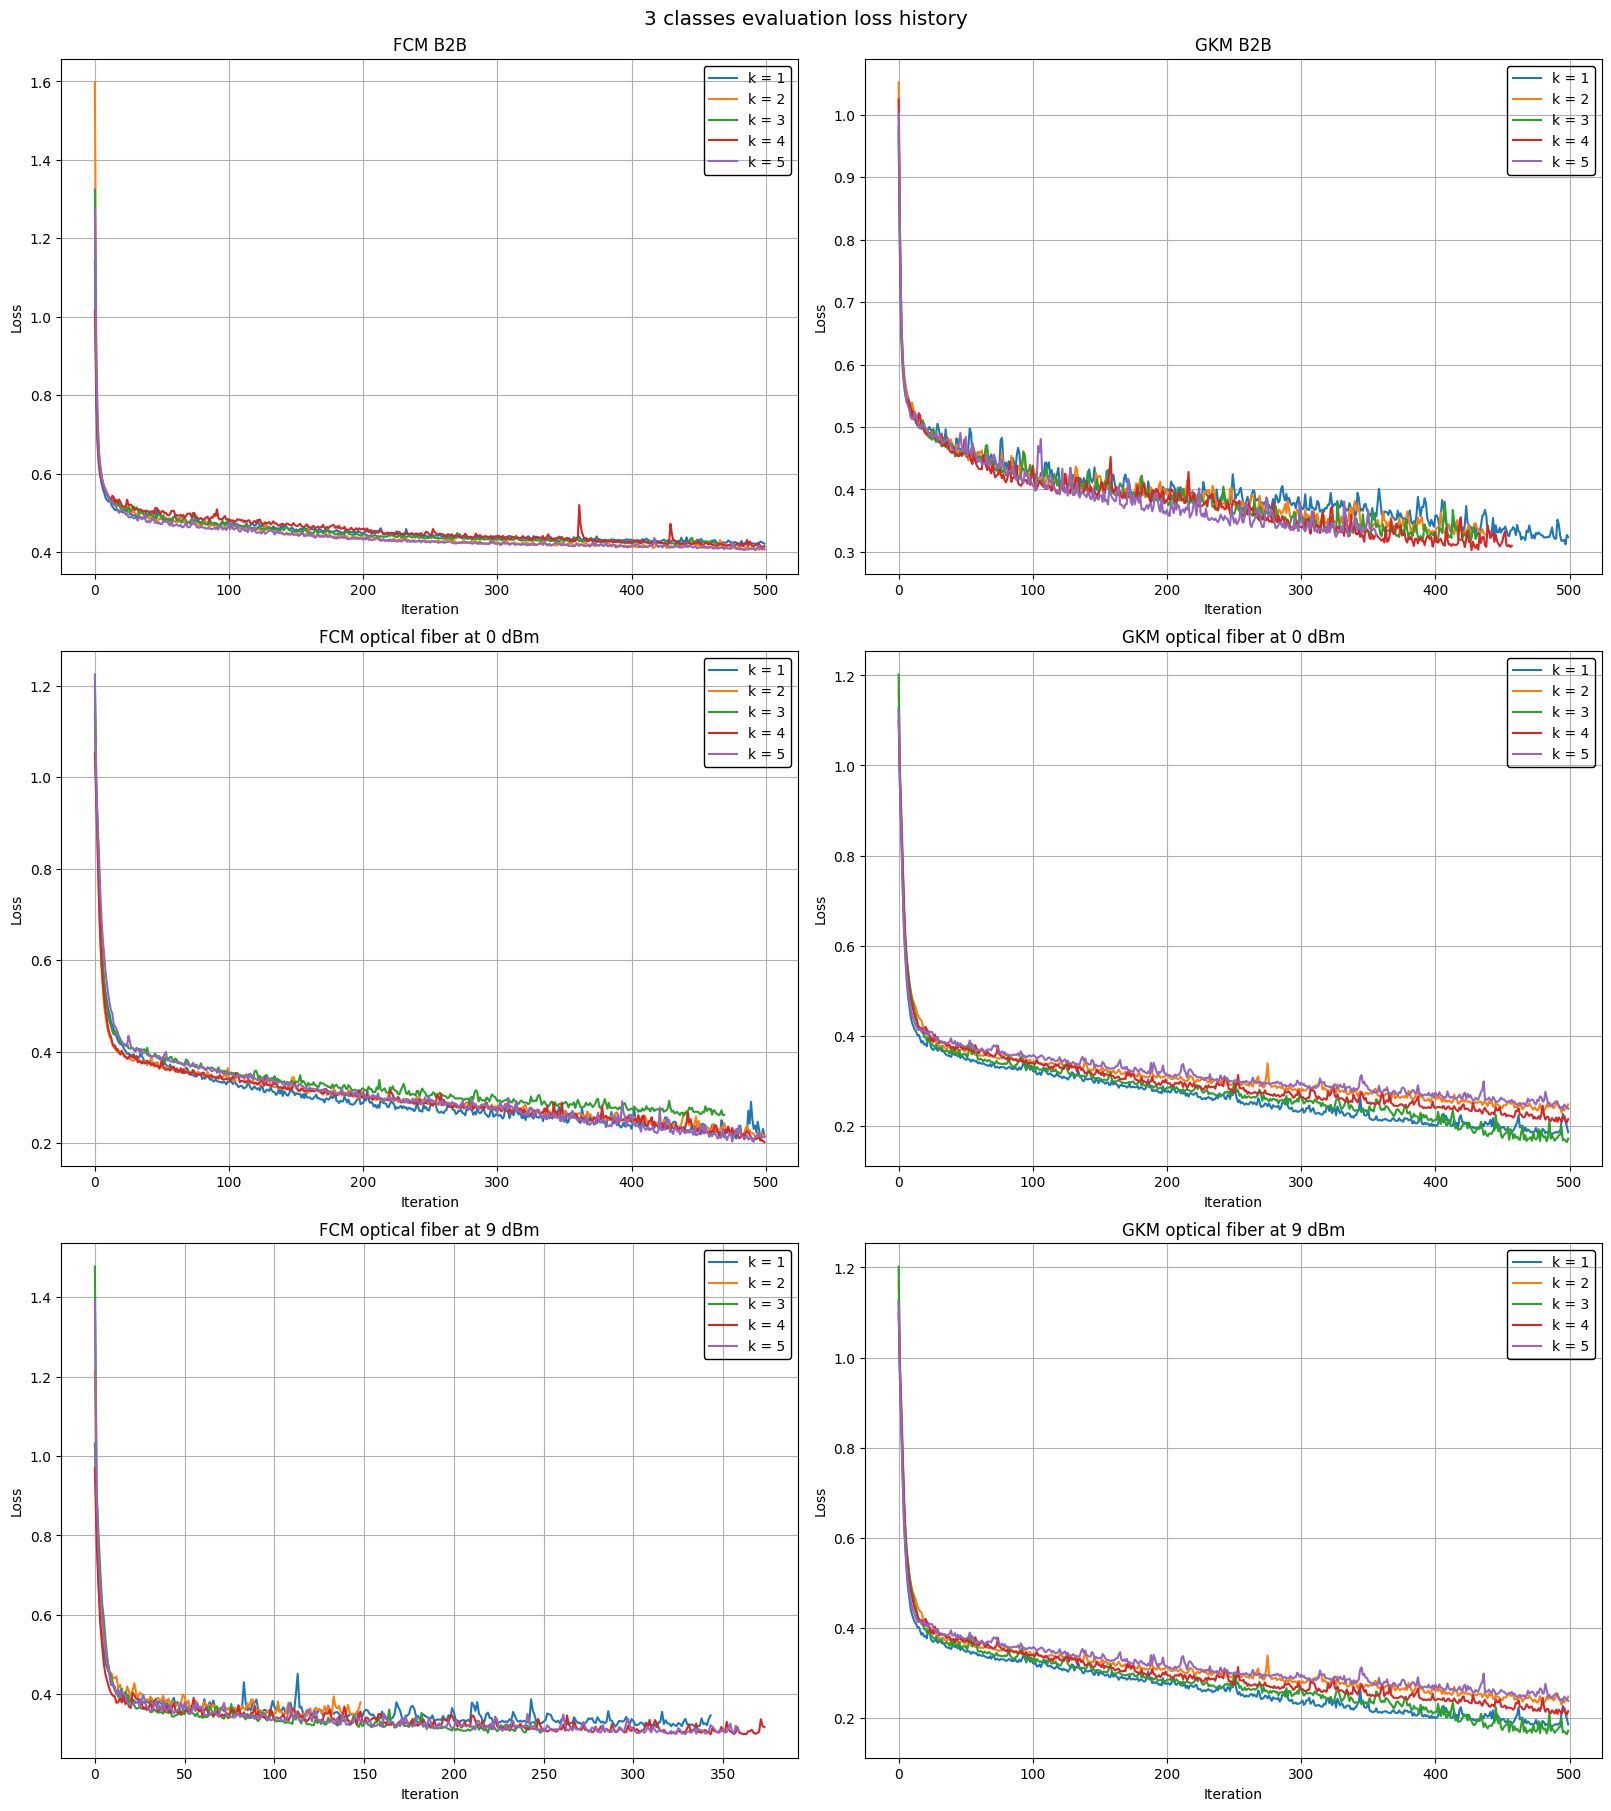

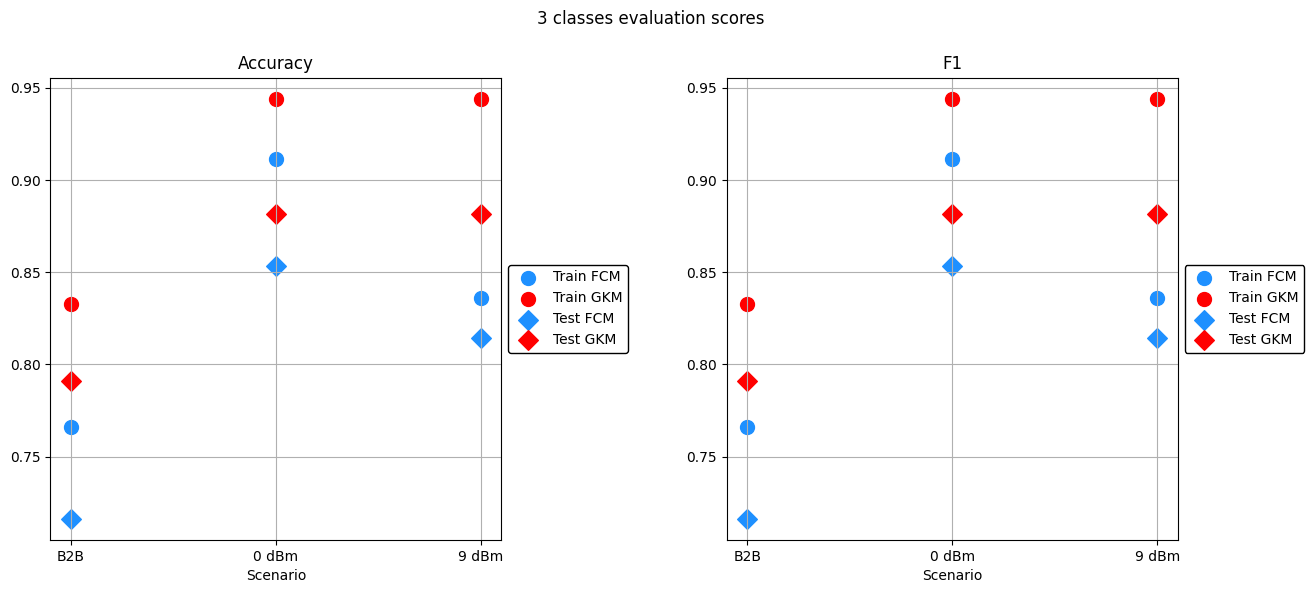

In [96]:
scores = [scores_3classes_FCM_B2B, scores_3classes_GKM_B2B, scores_3classes_FCM_fiber0, scores_3classes_GKM_fiber0, scores_3classes_FCM_fiber9, scores_3classes_GKM_fiber0]
plot_classes_scores(scores, "3 classes evaluation")

## 4 clases

### FCM

In [97]:
interval_lst = [(0, 31.5), (31.5, 33.5), (33.5, 35), (35, 50)]
df_4classes_FCM = classificator(df_FCM, interval_lst, "column_20")

# Scenarios split
# Back-to-back (B2B)
df_4classes_FCM_B2B = df_4classes_FCM[0:987, :]
# 0dBm optical fiber
df_4classes_FCM_fiber0 = df_4classes_FCM[988:1520, :]
# 9dBm optical fiber
df_4classes_FCM_fiber9 = df_4classes_FCM[1521:, :]

#### B2B

In [98]:
args = {"data": df_4classes_FCM_B2B, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy"}
scores_4classes_FCM_B2B = calc_once("scores_4classes_FCM_B2B", test_classification_model, args)

In [99]:
args = {"data": df_4classes_FCM_B2B, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy", "use_osnr": False}
scores_4classes_woOSNR_FCM_B2B = calc_once("scores_4classes_woOSNR_FCM_B2B", test_classification_model, args)

[{'units': 256, 'activation': 'relu'}, {'units': 128, 'activation': 'tanh'}, {'units': 64, 'activation': 'sigmoid'}]
Needed iterations: 574
7/7 [==============================] - 0s 935us/step
Needed iterations: 364
7/7 [==============================] - 0s 956us/step
Needed iterations: 469
7/7 [==============================] - 0s 1ms/step
Needed iterations: 415
7/7 [==============================] - 0s 917us/step
Needed iterations: 340
7/7 [==============================] - 0s 991us/step
Time elapsed: 0.55 minutes


#### Fibra óptica a 0dBm

In [100]:
args = {"data": df_4classes_FCM_fiber0, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy"}
scores_4classes_FCM_fiber0 = calc_once("scores_4classes_FCM_fiber0", test_classification_model, args)

In [101]:
args = {"data": df_4classes_FCM_fiber0, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy", "use_osnr": False}
scores_4classes_woOSNR_FCM_fiber0 = calc_once("scores_4classes_woOSNR_FCM_fiber0", test_classification_model, args)

[{'units': 256, 'activation': 'relu'}, {'units': 128, 'activation': 'tanh'}, {'units': 64, 'activation': 'sigmoid'}]
Needed iterations: 610
4/4 [==============================] - 0s 1ms/step
Needed iterations: 686
4/4 [==============================] - 0s 998us/step
Needed iterations: 582
4/4 [==============================] - 0s 1ms/step
Needed iterations: 468
4/4 [==============================] - 0s 1ms/step
Needed iterations: 336
4/4 [==============================] - 0s 1ms/step
Time elapsed: 0.41 minutes


#### Fibra óptica a 9dBm

In [102]:
args = {"data": df_4classes_FCM_fiber9, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy"}
scores_4classes_FCM_fiber9 = calc_once("scores_4classes_FCM_fiber9", test_classification_model, args)

In [103]:
args = {"data": df_4classes_FCM_fiber9, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy", "use_osnr": False}
scores_4classes_woOSNR_FCM_fiber9 = calc_once("scores_4classes_woOSNR_FCM_fiber9", test_classification_model, args)

[{'units': 256, 'activation': 'relu'}, {'units': 128, 'activation': 'tanh'}, {'units': 64, 'activation': 'sigmoid'}]
Needed iterations: 307
6/6 [==============================] - 0s 916us/step
Needed iterations: 410
6/6 [==============================] - 0s 1ms/step
Needed iterations: 428
6/6 [==============================] - 0s 864us/step
Needed iterations: 694
6/6 [==============================] - 0s 900us/step
Needed iterations: 327
6/6 [==============================] - 0s 946us/step
Time elapsed: 0.50 minutes


### GKM

In [104]:
interval_lst = [(0, 31.5), (31.5, 33.5), (33.5, 35), (35, 50)]
df_4classes_GKM = classificator(df_GKM, interval_lst, "column_20")

# Scenarios split
# Back-to-back (B2B)
df_4classes_GKM_B2B = df_4classes_GKM[0:987, :]
# 0dBm optical fiber
df_4classes_GKM_fiber0 = df_4classes_GKM[988:1520, :]
# 9dBm optical fiber
df_4classes_GKM_fiber9 = df_4classes_GKM[1521:, :]

#### B2B

In [105]:
args = {"data": df_4classes_GKM_B2B, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy"}
scores_4classes_GKM_B2B = calc_once("scores_4classes_GKM_B2B", test_classification_model, args)

In [106]:
args = {"data": df_4classes_GKM_B2B, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy", "use_osnr": False}
scores_4classes_woOSNR_GKM_B2B = calc_once("scores_4classes_woOSNR_GKM_B2B", test_classification_model, args)

[{'units': 256, 'activation': 'relu'}, {'units': 128, 'activation': 'tanh'}, {'units': 64, 'activation': 'sigmoid'}]
Needed iterations: 356
7/7 [==============================] - 0s 927us/step
Needed iterations: 203
7/7 [==============================] - 0s 1ms/step
Needed iterations: 524
7/7 [==============================] - 0s 838us/step
Needed iterations: 281
7/7 [==============================] - 0s 897us/step
Needed iterations: 338
7/7 [==============================] - 0s 913us/step
Time elapsed: 0.47 minutes


#### Fibra óptica a 0dBm

In [107]:
args = {"data": df_4classes_GKM_fiber0, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy"}
scores_4classes_GKM_fiber0 = calc_once("scores_4classes_GKM_fiber0", test_classification_model, args)

In [108]:
args = {"data": df_4classes_GKM_fiber0, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy", "use_osnr": False}
scores_4classes_woOSNR_GKM_fiber0 = calc_once("scores_4classes_woOSNR_GKM_fiber0", test_classification_model, args)

[{'units': 256, 'activation': 'relu'}, {'units': 128, 'activation': 'tanh'}, {'units': 64, 'activation': 'sigmoid'}]
Needed iterations: 482
4/4 [==============================] - 0s 1ms/step
Needed iterations: 690
4/4 [==============================] - 0s 969us/step
Needed iterations: 683
4/4 [==============================] - 0s 1ms/step
Needed iterations: 562
4/4 [==============================] - 0s 892us/step
Needed iterations: 469
4/4 [==============================] - 0s 1ms/step
Time elapsed: 0.44 minutes


#### Fibra óptica a 9dBm

In [109]:
args = {"data": df_4classes_GKM_fiber9, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy"}
scores_4classes_GKM_fiber9 = calc_once("scores_4classes_GKM_fiber9", test_classification_model, args)

In [110]:
args = {"data": df_4classes_GKM_fiber9, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy", "use_osnr": False}
scores_4classes_woOSNR_GKM_fiber9 = calc_once("scores_4classes_woOSNR_GKM_fiber9", test_classification_model, args)

[{'units': 256, 'activation': 'relu'}, {'units': 128, 'activation': 'tanh'}, {'units': 64, 'activation': 'sigmoid'}]
Needed iterations: 232
6/6 [==============================] - 0s 840us/step
Needed iterations: 292
6/6 [==============================] - 0s 896us/step
Needed iterations: 204
6/6 [==============================] - 0s 1ms/step
Needed iterations: 231
6/6 [==============================] - 0s 1ms/step
Needed iterations: 351
6/6 [==============================] - 0s 919us/step
Time elapsed: 0.34 minutes


In [ ]:
%store scores_4classes_FCM_B2B
%store scores_4classes_GKM_B2B
%store scores_4classes_FCM_fiber0
%store scores_4classes_GKM_fiber0
%store scores_4classes_FCM_fiber9
%store scores_4classes_GKM_fiber9

%store scores_4classes_woOSNR_FCM_B2B
%store scores_4classes_woOSNR_GKM_B2B
%store scores_4classes_woOSNR_FCM_fiber0
%store scores_4classes_woOSNR_GKM_fiber0
%store scores_4classes_woOSNR_FCM_fiber9
%store scores_4classes_woOSNR_GKM_fiber9

### Gráficas

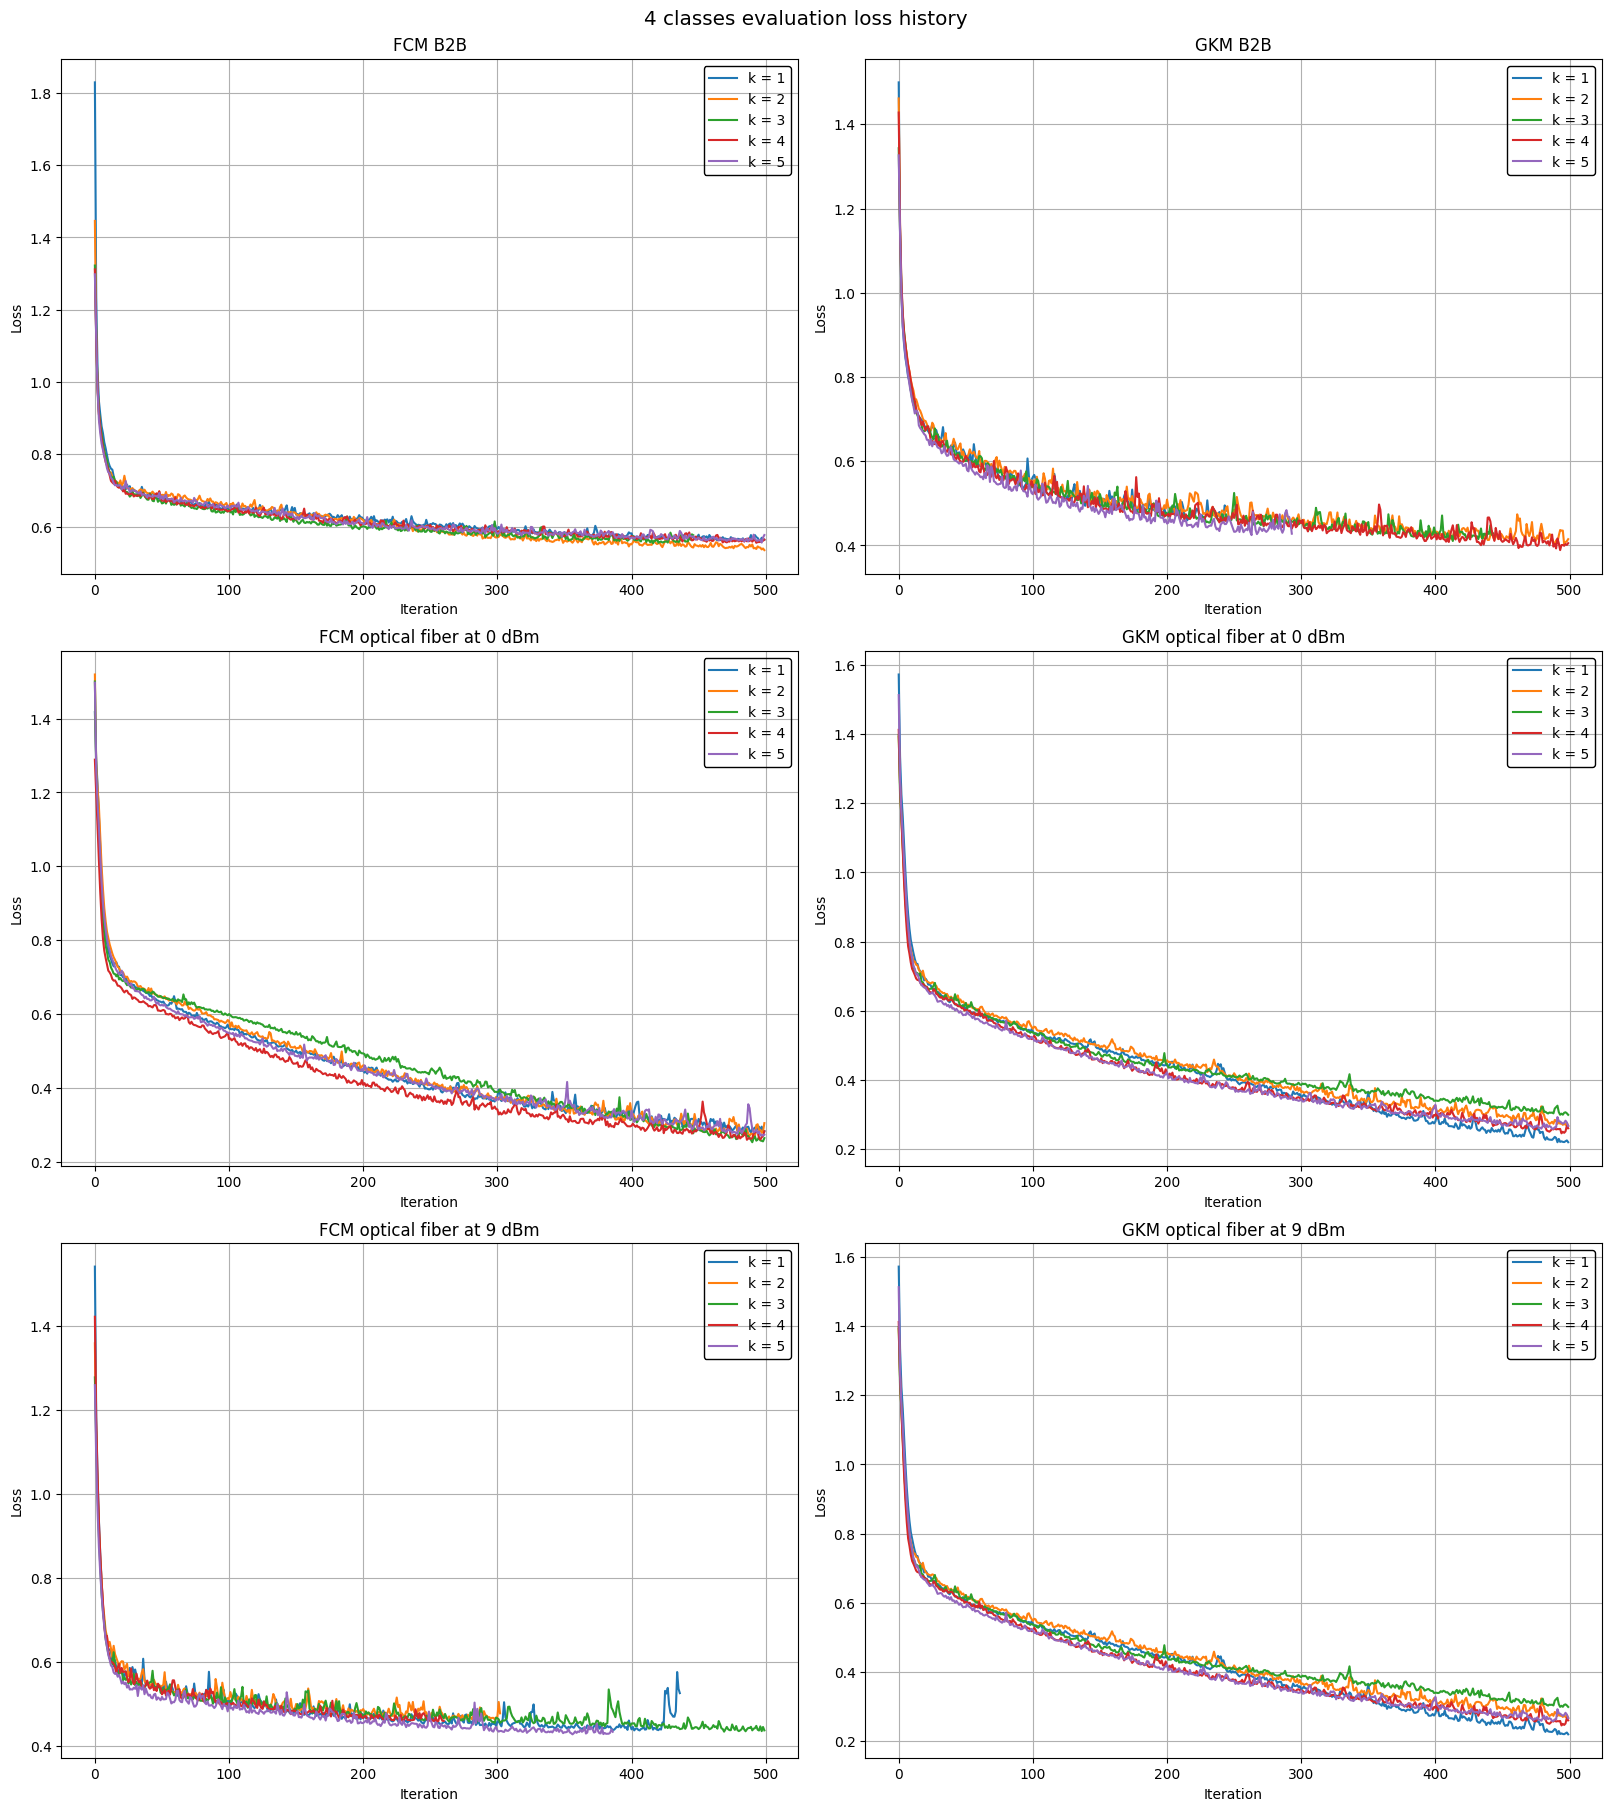

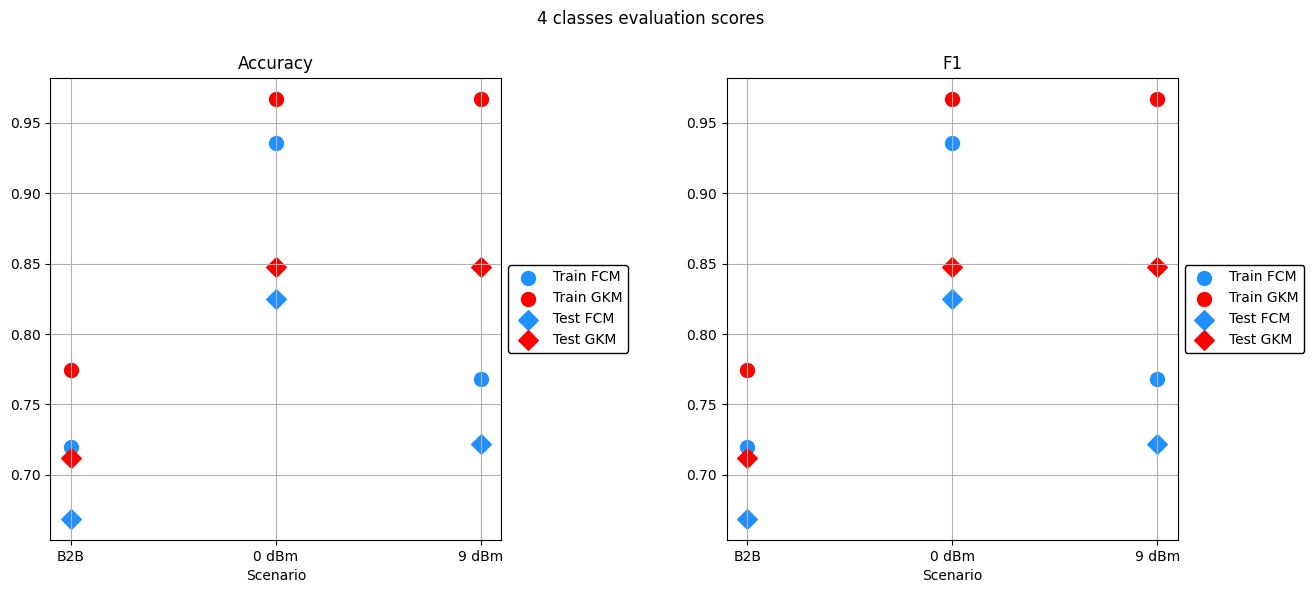

In [112]:
scores = [scores_4classes_FCM_B2B, scores_4classes_GKM_B2B, scores_4classes_FCM_fiber0, scores_4classes_GKM_fiber0, scores_4classes_FCM_fiber9, scores_4classes_GKM_fiber0]
plot_classes_scores(scores, "4 classes evaluation")

## 5 clases

### FCM

In [111]:
interval_lst = [(0, 31.5), (31.5, 33.5), (33.5, 35), (35, 37.5), (37.5, 50)]
df_5classes_FCM = classificator(df_FCM, interval_lst, "column_20")

# Scenarios split
# Back-to-back (B2B)
df_5classes_FCM_B2B = df_5classes_FCM[0:987, :]
# 0dBm optical fiber
df_5classes_FCM_fiber0 = df_5classes_FCM[988:1520, :]
# 9dBm optical fiber
df_5classes_FCM_fiber9 = df_5classes_FCM[1521:, :]

#### B2B

In [113]:
args = {"data": df_5classes_FCM_B2B, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy"}
scores_5classes_FCM_B2B = calc_once("scores_5classes_FCM_B2B", test_classification_model, args)

In [114]:
args = {"data": df_5classes_FCM_B2B, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy", "use_osnr": False}
scores_5classes_woOSNR_FCM_B2B = calc_once("scores_5classes_woOSNR_FCM_B2B", test_classification_model, args)

[{'units': 256, 'activation': 'relu'}, {'units': 128, 'activation': 'tanh'}, {'units': 64, 'activation': 'sigmoid'}]
Needed iterations: 373
7/7 [==============================] - 0s 2ms/step
Needed iterations: 481
7/7 [==============================] - 0s 805us/step
Needed iterations: 420
7/7 [==============================] - 0s 1ms/step
Needed iterations: 374
7/7 [==============================] - 0s 952us/step
Needed iterations: 684
7/7 [==============================] - 0s 824us/step
Time elapsed: 0.58 minutes


#### Fibra óptica a 0dBm

In [115]:
bargs = {"data": df_5classes_FCM_fiber0, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy"}
scores_5classes_FCM_fiber0 = calc_once("scores_5classes_FCM_fiber0", test_classification_model, args)

In [116]:
args = {"data": df_5classes_FCM_fiber0, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy", "use_osnr": False}
scores_5classes_woOSNR_FCM_fiber0 = calc_once("scores_5classes_woOSNR_FCM_fiber0", test_classification_model, args)

[{'units': 256, 'activation': 'relu'}, {'units': 128, 'activation': 'tanh'}, {'units': 64, 'activation': 'sigmoid'}]
Needed iterations: 1360
4/4 [==============================] - 0s 2ms/step
Needed iterations: 887
4/4 [==============================] - 0s 1ms/step
Needed iterations: 480
4/4 [==============================] - 0s 1ms/step
Needed iterations: 1308
4/4 [==============================] - 0s 1ms/step
Needed iterations: 1065
4/4 [==============================] - 0s 961us/step
Time elapsed: 0.72 minutes


#### Fibra óptica a 9dBm

In [118]:
args = {"data": df_5classes_FCM_fiber9, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy"}
scores_5classes_FCM_fiber9 = calc_once("scores_5classes_FCM_fiber9", test_classification_model, args)

In [117]:
args = {"data": df_5classes_FCM_fiber9, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy", "use_osnr": False}
scores_5classes_woOSNR_FCM_fiber9 = calc_once("scores_5classes_woOSNR_FCM_fiber9", test_classification_model, args)

[{'units': 256, 'activation': 'relu'}, {'units': 128, 'activation': 'tanh'}, {'units': 64, 'activation': 'sigmoid'}]
Needed iterations: 271
6/6 [==============================] - 0s 1ms/step
Needed iterations: 573
6/6 [==============================] - 0s 1ms/step
Needed iterations: 567
6/6 [==============================] - 0s 2ms/step
Needed iterations: 426
6/6 [==============================] - 0s 1ms/step
Needed iterations: 830
6/6 [==============================] - 0s 905us/step
Time elapsed: 0.64 minutes


### GKM

In [119]:
interval_lst = [(0, 31.5), (31.5, 33.5), (33.5, 35), (35, 37.5), (37.5, 50)]
df_5classes_GKM = classificator(df_GKM, interval_lst, "column_20")

# Scenarios split
# Back-to-back (B2B)
df_5classes_GKM_B2B = df_5classes_GKM[0:987, :]
# 0dBm optical fiber
df_5classes_GKM_fiber0 = df_5classes_GKM[988:1520, :]
# 9dBm optical fiber
df_5classes_GKM_fiber9 = df_5classes_GKM[1521:, :]

#### B2B

In [120]:
args = {"data": df_5classes_GKM_B2B, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy"}
scores_5classes_GKM_B2B = calc_once("scores_5classes_GKM_B2B", test_classification_model, args)

In [121]:
args = {"data": df_5classes_GKM_B2B, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy", "use_osnr": False}
scores_5classes_woOSNR_GKM_B2B = calc_once("scores_5classes_woOSNR_GKM_B2B", test_classification_model, args)

[{'units': 256, 'activation': 'relu'}, {'units': 128, 'activation': 'tanh'}, {'units': 64, 'activation': 'sigmoid'}]
Needed iterations: 362
7/7 [==============================] - 0s 787us/step
Needed iterations: 397
7/7 [==============================] - 0s 958us/step
Needed iterations: 939
7/7 [==============================] - 0s 1ms/step
Needed iterations: 491
7/7 [==============================] - 0s 981us/step
Needed iterations: 593
7/7 [==============================] - 0s 1ms/step
Time elapsed: 0.74 minutes


#### Fibra óptica a 0dBm

In [122]:
args = {"data": df_5classes_GKM_fiber0, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy"}
scores_5classes_GKM_fiber0 = calc_once("scores_5classes_GKM_fiber0", test_classification_model, args)

In [123]:
args = {"data": df_5classes_GKM_fiber0, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy", "use_osnr": False}
scores_5classes_woOSNR_GKM_fiber0 = calc_once("scores_5classes_woOSNR_GKM_fiber0", test_classification_model, args)

[{'units': 256, 'activation': 'relu'}, {'units': 128, 'activation': 'tanh'}, {'units': 64, 'activation': 'sigmoid'}]
Needed iterations: 767
4/4 [==============================] - 0s 3ms/step
Needed iterations: 864
4/4 [==============================] - 0s 971us/step
Needed iterations: 802
4/4 [==============================] - 0s 1ms/step
Needed iterations: 897
4/4 [==============================] - 0s 1ms/step
Needed iterations: 1329
4/4 [==============================] - 0s 935us/step
Time elapsed: 0.67 minutes


#### Fibra óptica a 9dBm

In [124]:
args = {"data": df_5classes_GKM_fiber9, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy"}
scores_5classes_GKM_fiber9 = calc_once("scores_5classes_GKM_fiber9", test_classification_model, args)

In [125]:
args = {"data": df_5classes_GKM_fiber9, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy", "use_osnr": False}
scores_5classes_woOSNR_GKM_fiber9 = calc_once("scores_5classes_woOSNR_GKM_fiber9", test_classification_model, args)

[{'units': 256, 'activation': 'relu'}, {'units': 128, 'activation': 'tanh'}, {'units': 64, 'activation': 'sigmoid'}]
Needed iterations: 315
6/6 [==============================] - 0s 844us/step
Needed iterations: 413
6/6 [==============================] - 0s 986us/step
Needed iterations: 371
6/6 [==============================] - 0s 854us/step
Needed iterations: 389
6/6 [==============================] - 0s 3ms/step
Needed iterations: 275
6/6 [==============================] - 0s 930us/step
Time elapsed: 0.45 minutes


In [126]:
%store scores_5classes_FCM_B2B
%store scores_5classes_GKM_B2B
%store scores_5classes_FCM_fiber0
%store scores_5classes_GKM_fiber0
%store scores_5classes_FCM_fiber9
%store scores_5classes_GKM_fiber9

%store scores_5classes_woOSNR_FCM_B2B
%store scores_5classes_woOSNR_GKM_B2B
%store scores_5classes_woOSNR_FCM_fiber0
%store scores_5classes_woOSNR_GKM_fiber0
%store scores_5classes_woOSNR_FCM_fiber9
%store scores_5classes_woOSNR_GKM_fiber9

Stored 'scores_5classes_FCM_B2B' (dict)
Stored 'scores_5classes_GKM_B2B' (dict)
Stored 'scores_5classes_FCM_fiber0' (dict)
Stored 'scores_5classes_GKM_fiber0' (dict)
Stored 'scores_5classes_FCM_fiber9' (dict)
Stored 'scores_5classes_GKM_fiber9' (dict)
Stored 'scores_5classes_woOSNR_FCM_B2B' (dict)
Stored 'scores_5classes_woOSNR_GKM_B2B' (dict)
Stored 'scores_5classes_woOSNR_FCM_fiber0' (dict)
Stored 'scores_5classes_woOSNR_GKM_fiber0' (dict)
Stored 'scores_5classes_woOSNR_FCM_fiber9' (dict)
Stored 'scores_5classes_woOSNR_GKM_fiber9' (dict)


### Gráficas

In [ ]:
scores = [scores_5classes_FCM_B2B, scores_5classes_GKM_B2B, scores_5classes_FCM_fiber0, scores_5classes_GKM_fiber0, scores_5classes_FCM_fiber9, scores_5classes_GKM_fiber0]
plot_classes_scores(scores, "5 classes evaluation")

## Gráfica final

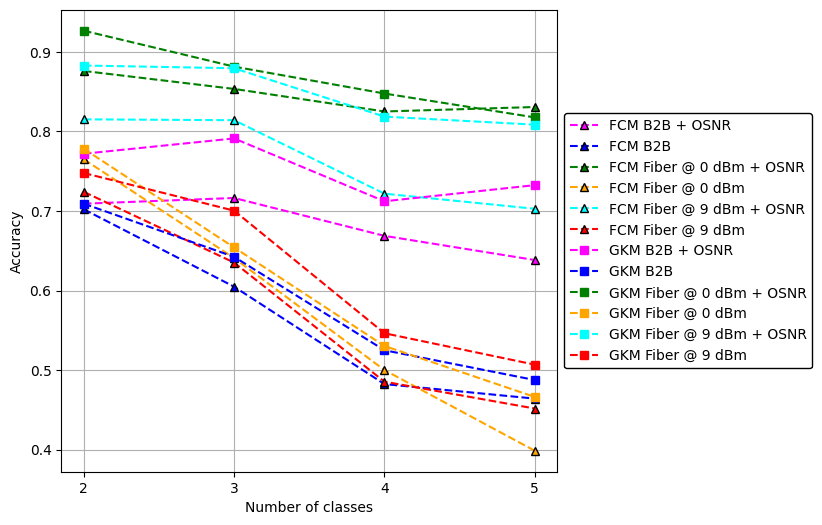

In [14]:
algorithms = ["FCM", "GKM"]
classes_n = [2, 3, 4, 5]
scenarios = ["B2B", "fiber0", "fiber9"]
OSNR = ["", "_woOSNR"]
classes_scores = {f"scores{osnr}_{algo}_{scenario}":
                  [np.average(
                      eval(f"scores_{n}classes{osnr}_{algo}_{scenario}").get(
                          "acc"
                      ).get(
                          "test"
                      )
                  ) for n in classes_n]
                  for algo in algorithms for osnr in OSNR for scenario in scenarios
                 }
# Markers for algorithm 
markers = {"FCM": "^", "GKM": "s"}

# Colors for scenario (blue for B2B, orange for 0dBm, red for 9dBm)
colors = {"B2B": ["blue", "magenta"], "fiber0": ["orange", "green"], "fiber9": ["red", "cyan"]}

plt.figure(figsize=(8, 6), layout="constrained")
ax = plt.subplot(1, 1, 1)
for algo in algorithms:
    for scenario in scenarios:
        for osnr in OSNR:
            scenario_label = "Fiber @ 0 dBm" if scenario == "fiber0" else "Fiber @ 9 dBm" if scenario != "B2B" else scenario
            OSNR_label = "+ OSNR" if osnr == "" else ""
            label = f"{algo} {scenario_label} {OSNR_label}"
            color = colors.get(scenario)[0 if OSNR_label == "" else 1]
            marker = markers.get(algo)
            markeredgecolor = "black" if algo == "FCM" else None
            plt.plot(classes_n, classes_scores.get(f"scores{osnr}_{algo}_{scenario}"),
                     color=color, marker=marker, linestyle="--",
                     markeredgecolor=markeredgecolor,
                     label=f"{label}")
plt.xlabel("Number of classes")
ax.set_xticks(classes_n)
plt.ylabel("Accuracy")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Transparent white box black edge legend
legend = plt.legend(loc="center left", bbox_to_anchor=(1, 0.5),
                    edgecolor="black")
legend.get_frame().set_alpha(None)
legend.get_frame().set_facecolor((1, 1, 1, 0.01))
plt.grid(True)

plt.savefig("classes.svg", format="svg", transparent=True, bbox_inches="tight")

In [12]:
classes_scores

{'scores_FCM_B2B': [0.709172947751628,
  0.7163564579808235,
  0.6687381428498179,
  0.6383223093882993],
 'scores_FCM_fiber0': [0.8761065067889262,
  0.8535178980779404,
  0.8251454769881856,
  0.830770587198025],
 'scores_FCM_fiber9': [0.8152732812797563,
  0.8141877737573795,
  0.721805370405637,
  0.702780422776614],
 'scores_woOSNR_FCM_B2B': [0.7021124955135107,
  0.6047736245705788,
  0.4822950315336102,
  0.46405681177254776],
 'scores_woOSNR_FCM_fiber0': [0.7649797213895256,
  0.6408393581378945,
  0.49994709927702347,
  0.3985011461823311],
 'scores_woOSNR_FCM_fiber9': [0.7240652574112868,
  0.6351107725512601,
  0.48532977845489744,
  0.45157747730590997],
 'scores_GKM_B2B': [0.7720145618622776,
  0.791262882633441,
  0.712208378198226,
  0.7325026918935549],
 'scores_GKM_fiber0': [0.9267148651031564,
  0.8815552812555106,
  0.8477340856991713,
  0.817704108622818],
 'scores_GKM_fiber9': [0.8829365835079033,
  0.8795277090078081,
  0.8186821557798515,
  0.8085634482320827],
 

In [ ]:
scores = [scores_2classes_FCM_B2B, scores_3classes_FCM_B2B, scores_4classes_FCM_B2B, scores_5classes_FCM_B2B]
scores_classes_FCM_B2B = [float(np.average(score_classes_FCM_B2B.get("acc").get("test"))) for score_classes_FCM_B2B in scores]

scores = [scores_2classes_FCM_fiber0, scores_3classes_FCM_fiber0, scores_4classes_FCM_fiber0, scores_5classes_FCM_fiber0]
scores_classes_FCM_fiber0 = [float(np.average(score_classes_FCM_fiber0.get("acc").get("test"))) for score_classes_FCM_fiber0 in scores]

scores = [scores_2classes_FCM_fiber9, scores_3classes_FCM_fiber9, scores_4classes_FCM_fiber9, scores_5classes_FCM_fiber9]
scores_classes_FCM_fiber9 = [float(np.average(score_classes_FCM_fiber9.get("acc").get("test"))) for score_classes_FCM_fiber9 in scores]

classifier_FCM_df = pl.DataFrame(
        {"Classes": range(2, 6), "B2B": scores_classes_FCM_B2B, "Fiber @ 0dBm": scores_classes_FCM_fiber0, "Fiber @ 9dBm": scores_classes_FCM_fiber9}
    )

classifier_FCM_df

In [ ]:
scores = [scores_2classes_GKM_B2B, scores_3classes_GKM_B2B, scores_4classes_GKM_B2B, scores_5classes_GKM_B2B]
scores_classes_GKM_B2B = [float(np.average(score_classes_GKM_B2B.get("acc").get("test"))) for score_classes_GKM_B2B in scores]

scores = [scores_2classes_GKM_fiber0, scores_3classes_GKM_fiber0, scores_4classes_GKM_fiber0, scores_5classes_GKM_fiber0]
scores_classes_GKM_fiber0 = [float(np.average(score_classes_GKM_fiber0.get("acc").get("test"))) for score_classes_GKM_fiber0 in scores]

scores = [scores_2classes_GKM_fiber9, scores_3classes_GKM_fiber9, scores_4classes_GKM_fiber9, scores_5classes_GKM_fiber9]
scores_classes_GKM_fiber9 = [float(np.average(score_classes_GKM_fiber9.get("acc").get("test"))) for score_classes_GKM_fiber9 in scores]

classifier_GKM_df = pl.DataFrame(
        {"Classes": range(2, 6), "B2B": scores_classes_GKM_B2B, "Fiber @ 0dBm": scores_classes_GKM_fiber0, "Fiber @ 9dBm": scores_classes_GKM_fiber9}
    )

classifier_GKM_df